# Electronics Worked Example

This notebook starts to explore a worked example of how we can use a package like `lcapy` to support the production of technical eductional materials in a way that guarantees correctness and provides opportunities to developing self-text activities.

## `lcapy`

As described elsewhere, `lcapy` is a linear circuit analysis package that can be used to describe, display and analyse the behaviour of a wide range of linear analogue electrical circuits.

`lcapy` use a circuit description that can be used to generate an circuit diagram as the basis for a wide range of analyses.

In [1]:
%%capture
try:
    import lcapy
except:
    %pip install lcapy
    
#  https://github.com/dawbarton/pdf2svg
#!brew install pdf2svg

Circuits are defined by generating a graph that connects numbered nodes with edges representating a particular component. Layout instructions describe the orientation of the edge, and labels can be added as required.

In actual use, it would make sense to build up a lirary of comment circuit blocks that can be visually reviewed, and then the corresponding definition copited and reused, with modification as required.

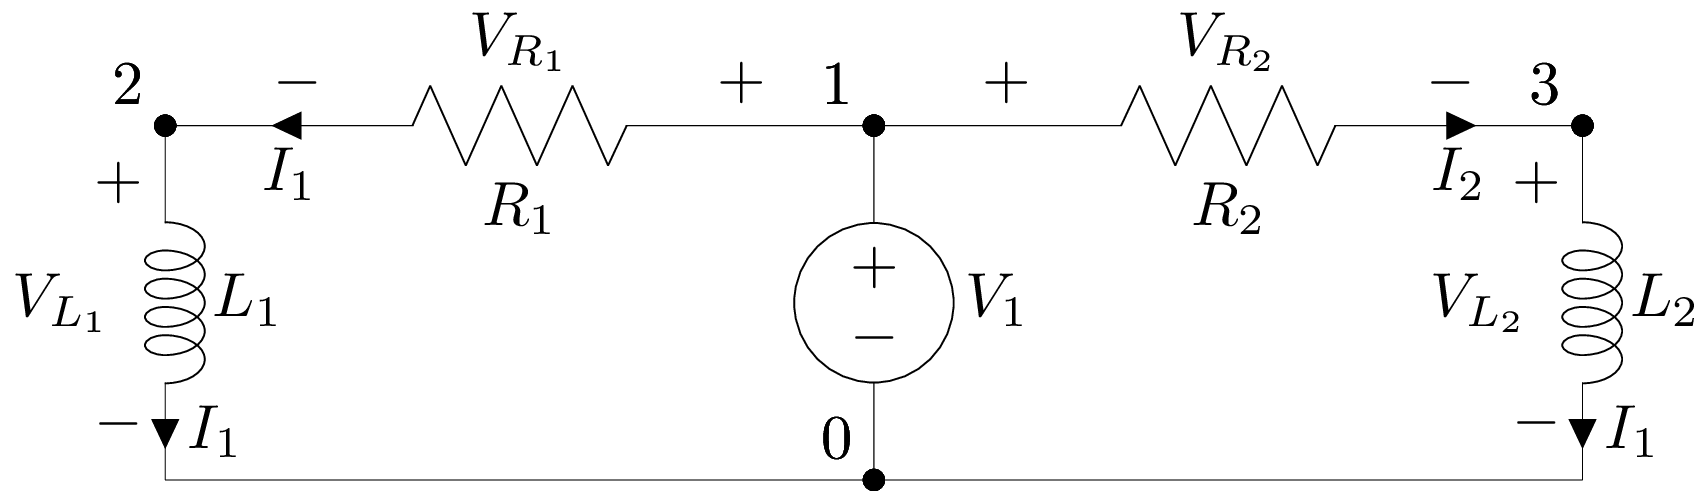

In [2]:
from lcapy import Circuit

cct = Circuit("""
V1 1 0; down
R1 1 2; left=2, i=I_1, v=V_{R_1}
R2 1 3; right=2, i=I_2, v=V_{R_2}
L1 2 0_1; down, i=I_1, v=V_{L_1}
L2 3 0_3; down, i=I_1, v=V_{L_2}
W 0 0_3; right
W 0 0_1; left""")


# Render the circuit
cct.draw(scale=3)

# We can also save a generated circuit diagram to an image file
#cct.draw(scale=3, filename='circuit_diagram.svg')

## Example Production Workflow

To provide an example of how we might use `lcapy` consider the following teaching example taken from *The following section is a reworking of http://www.open.edu/openlearn/science-maths-technology/introduction-electronics/content-section-3.1 .* 

### Voltage Divider

Voltage dividers are widely used in electronic circuits to create a reference voltage, or to reduce the amplitude of a signal. The figure below shows a voltage divider. The value of $V_{out}$ can be calculated from the values of $V_S$, $R_1$ and $R_2$.

In [3]:
import lcapy
from lcapy import Circuit

#We can create a schematic for the voltage divider using lcapy
#This has the advantage that circuit description is also a model 
#The model can be analysed and used to calculate voltages and currents, for example,
#  across components if component values and the source voltage are defined

#Figure:  A voltage divider circuit
sch='''
VS 1 0 ; down
W 1 2 ;  right, size=2
R1 2 3 ; down
R2 3 4; down
W 3 5; right
P1 5 6; down,v=V_{out}
W 4 6; right
W 4 0; left
'''

#Demonstrate thate we can write the descriptioon to a file 
fn="voltageDivider.sch"
with open(fn, "w") as text_file:
    text_file.write(sch)

#  and then create the circuit model from the (persisted) file    
cct = Circuit(fn)

The schema is also retrievable from the circuit object:

In [4]:
cct.sch


VS 1 0 ; down
W 1 2 ;  right, size=2
R1 2 3 ; down
R2 3 4; down
W 3 5; right
P1 5 6; down,v=V_{out}
W 4 6; right
W 4 0; left

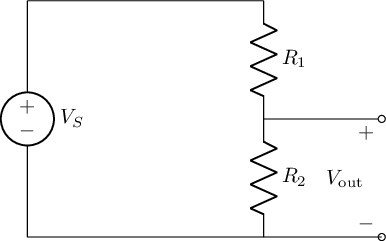

In [5]:
#Draw the circuit diagram that corresponds to the schematic description
cct.draw(style='american', draw_nodes=False, label_nodes=False) #american, british, european
#Draw function is defined in https://github.com/mph-/lcapy/blob/master/lcapy/schematic.py
#The styles need tweaking to suit OU convention - this requires a minor patch to lcapy
#Styles defined in https://github.com/mph-/lcapy/blob/master/lcapy/schematic.py#Schematic.tikz_draw

In the first instance, let’s assume that  is not connected to anything (for voltage dividers it is always assumed that negligible current flows through ). This means that, according to Kirchhoff’s first law, the current flowing through  is the same as the current flowing through . Ohm’s law allows you to calculate the current through $R_1$. It is the potential difference across that resistor, divided by its resistance. Since the voltage  is distributed over two resistors, the potential drop over $R_1$ is $V_{R_1}=V_S - V_{out}$.

The equation at the end of the last paragraph is written explicitly as LateX.

But we can also analyse the circuit using `lcapy` to see what the equation *should* be by deriving it automatically:

The voltage across $R_2$, $V_{out}$, is given as:

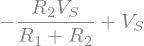

In [6]:
cct.R1.v

#We can't do anything about the order of the variables in the output expression, unfortunately
#It would be neater if sympy sorted fractional terms last but it doesn't...

We can get an expression for the output voltage, $V_{out}$, or its calculated value in a couple of ways:

```{note}
The circuit's node numbers can be displayed on the schematic if required: simply set `label_nodes=True` in the `draw()` statement.
```

For example, we can find the voltage across the appropriately numbered nodes by getting the open circuit voltage across nodes 3 and 4 (that is, across R2).

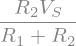

In [7]:
cct.Voc(3,4)['t']

The output voltage can also be obtained by direct reference to the appropriate component:

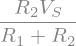

In [8]:
cct.R2.v

We can create a reference for our voltages as symbolic elements.

For example, we can get an expression for $V_{out}$:

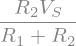

In [9]:
#sympy is a symbolic maths package
from sympy import Symbol, Eq

#If we add .expr to the voltages, we can get the sympy representation of voltage and current equations
# that are automatically derived from the model.
vout_expr = cct.R2.v.expr

vout_expr

We can also reference this value via a string:

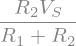

In [10]:
out_component = 'R2'

cct[out_component].v.expr

In [11]:
cct.R2.relname

'R2'

And an expression for the voltage across $R_1$:

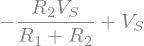

In [12]:
v_r1_expr = cct.R1.v.expr

v_r1_expr

Working with sympy symbols, we can perform a substitution if expressions match exactly.

In this case, we can swap in $V_{out}$ for the expression returned from the analysis to give us an expression in the form we want for $R_1$:

In [13]:
vout = Symbol('V_out')

v_r1_expr.subs(vout_expr, vout)

We can now create an equation to declare the relationship between a symbol for $R_1$ and the expression that defines its value:

In [14]:
#I don't know how to get the symbols from the circuit as sympy symbols
# so create them explicitly

v_r1 = Symbol("V_{R_1}")

# Define the equation
Eq( v_r1, v_r1_expr.subs(vout_expr, vout) )

```{note}
In a traditional set of teaching materials, we might work through the derivations of various formulae describing how to calculate particulalr quantities.

In order to render symbols correctly, we might author our document using LaTeX. Jupyter notebooks are quite comfortable with rendering LaTeX inline, or as part of a multiline block, so let's create an example of the sort of proof we might see in a traditionally authored text.

*The following expressions are hand written using LaTeX*
```

The current through $R_1$ ($I_{R_1}$) is given by $I_{R_1}=\displaystyle\frac{(V_S-V_{out})}{R_1}$

Similarly, the current through $R_2$ is given by $I_{R_2}=\displaystyle\frac{V_{out}}{R_2}$

Kirchoff’s first law tells you that $I_{R_1}=I_{R_2}=$, and therefore 

$\displaystyle\frac{V_{out}}{V_{R_2}}=\frac{(V_S-V_{out})}{R_1}$ 

Multiplying both sides by $R_1$ and by $R_2$ gives

$R_1V_{out}=R_2(V_S-V_{out})$

Then multiplying out the brackets on the right-hand side gives

$R_1V_{out}=R_2V_S-R_2V_{out}$

This can be rearranged to

$R_1V_{out}+R_2V_{out}=R_2V_S$

giving

$(R_1+R_2)V_{out}=R_2V_S$

and therefore the fundamental result is obtained:

$V_{out}=\displaystyle\frac{R_2V_S}{(R_1+R_2)}$

```{note}
One thing we might note at this point is that by authoring in the proof in the same document as the circuit diagram, we reduce the "distance" between the circuit diagram and the derivation that purports to relate to it but there is still the potential for error.

The distance between the image and the derivation also means that if we change the labeling on the diagram, for example, the derivation will no longer properly describe the components as labeled in the diagram.
```

From our symbolic expressions, we can render an equation for $V_{out}$ very straightforwardly:

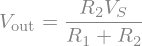

In [15]:
#We can find this from quantities we have derived through analysis of the presented circuit
Eq(vout, vout_expr)

Recall that the expression `vout_expr` was calculated automatically from the original circuit representation, which was also used to render the circuit diagram. The expression is guaranteed to be correct for the circuit we have defined, although it may not be presented in the order of the form we would like it to be in.

As well as accessing the voltage across a component, we can also access and expression for the current flowing through a component.

For example, let's get the expression for the current flowing through $R_1$ and assign it to an appropriate symbol:

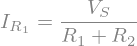

In [16]:
Eq(Symbol('I_{R_1}'), cct.R1.i.expr)

# The following equation is generated by the symbolic analysis...

```{note}
There is still distance in each of these uses of `Eq()`, where we "casually" state the equivalence of left and right hand components. Could we derive the symbol for the left hand side automatically, somehow?
```

We can also get an expression for the current through $R_2$:

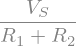

In [17]:
#We get the following from the circuit analysis, as above...
cct.R2.i.expr

# We note that the circuit analysis returns equal expressions for I_R_1 and I_R_2
# which gives some sort of reinforcement to the idea of Kirchoff's Law...

# The following equation is generated by the symbolic analysis...

Being able to render expressions that describe the values of particular quantities in algebraic terms means we may be able to create derivations that are "necessarily" true.

But we can do more than that, and also start to insert numbers into the expressions.

Consider the following exercise:

#### Exercise

Suppose  $V_S= 24 V$ and $R_2 = 100\Omega$. You want $V_{out} = 6 V$. What value of $R_1$ do you need?

#### Answer

```{note}
In a traditional set of materials, we are likely to write out the steps to the solution manually (a process which is subject to error and likely to need checking for correctness as well as sense) and then manually substitute in the required values and perform the calculation (which requires more checking).
```

Rearranging the equation for $V_{out}$ gives

$V_{out}(R_1+R_2)=R_2V_S$

and therefore:

$(R_1+R_2)=\displaystyle\frac{R_2V_S}{V_{out}}$

which means the equation for $R_1$ is:

$R_1=\displaystyle\frac{R_2V_S}{V_{out}}-R_2$

Substituting in the values given and performing the calculation gives us the required solution:

$R_1=\displaystyle\frac{100\Omega \times 24V}{6V}-100\Omega = 400\Omega-100\Omega=300\Omega$

```{note}
Once again, all the above steps are manuually derived and presented using hand crafted LaTex.
```


How might we set about creating an equivalent solution, but guaranteed to be correct?

We essentially want to solve for $R_1$ in the following expression (which was automatically derived by analysis of the presented circuit representation):

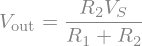

In [18]:
Eq(vout, vout_expr)

The steps we need to take are a simplification of the expression, with value substitution:

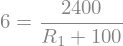

In [19]:
from sympy import sympify

#This is clunky - is there a proper way of substituting values into lcapy expressions?
Eq(6, sympify(str(vout_expr)).subs([('VS', 24), ('R2', 100)]))

Rearranging, we need to solve the following for $R_1$, generated the output expression automatically through symbolic analysis:

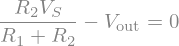

In [20]:
Eq(vout_expr - vout, 0)

`sympy` can solve such equations for us directly, so let's see how it solves things symbolically for $R_1$:

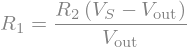

In [21]:
from sympy import solve

Eq(Symbol('R1'),solve(sympify(str(vout_expr-vout)),'R1')[0])

#The following equation is generated by the symbolic analysis...

To solve the equation numerically, we can substitute values into the `sympy` expression as follows:

In [22]:
solve(sympify(str(vout_expr-vout)).subs([('VS',24), ('R2',100),('V_out',6)]),'R1')[0]

We can craft an equation to display the solution for us:

In [23]:
VALUES = [('VS', 24),
          ('R2', 100),
          ('V_out', 6)]

SOLVE_FOR = 'R1'

Eq(Symbol(SOLVE_FOR), solve(sympify(str(vout_expr-vout)), SOLVE_FOR)[0].subs(VALUES))

#The following result is calculated by the symbolic analysis...

A key point about this is that we can script in different component values and display the correct output.

We can also do partial solutions which might be useful if we want to build up the steps to a solution, with partial substitution of values along the way:

In [24]:
Vs=20; Vout=5
R1=solve(sympify(str(vout_expr-vout)),'R1')[0].subs([('VS',Vs),('V_out',Vout)])

print('For V_S={Vs}V and V_out={Vout}V, we need R1={R1}.'.format(Vs=Vs,Vout=Vout,R1=R1))

For V_S=20V and V_out=5V, we need R1=3*R2.


Alternatively, we can create a function to solve for any single missing value.

The following will calculate the relevant solution:

In [25]:
def soln(cct, out_component=None, values=None):
    if values is None:
        values={'VS':24, 'R1':'', 'R2':100, 'V_out':6}
    outval=[v for v in values if not values[v]]
    invals=[(v, values[v]) for v in values if values[v] ]
    if len(outval)!=1 or len(invals)!=3:
        return 'oops'
    
    outval = outval[0]
    out_component = out_component if out_component else outval
    vout_expr = cct[out_component].v.expr
    print(vout_expr)
    print(invals)
    return 'Value of {} is {}'.format(outval,
                                      solve(sympify(str(vout_expr-vout)).subs(invals), outval)[0])


For example, using the default values baked into the function:

In [26]:
soln(cct, 'R2')

R2*VS/(R1 + R2)
[('VS', 24), ('R2', 100), ('V_out', 6)]


'Value of R1 is 300'

Or using values we pass in:

In [27]:
soln(cct, 'R2', {'VS':24, 'R2':'', 'R1':300, 'V_out':6})

R2*VS/(R1 + R2)
[('VS', 24), ('R1', 300), ('V_out', 6)]


'Value of R2 is 100'

With these pieces in place, we can also consider how we might automatically generate circuit diagrams with specifed component values, and then perform, or check, calculations against them.

For example, the following function wraps a specific circuit definition and allows specific component values to be passed in:

In [28]:
#We can also explore a simple thing to check the value from a circuit analysis
def cct1(V='24',R1='100',R2='100'):
    R1 = '' if R1 and float(R1) <=0 else R1
    sch='''
    VS 1 0 {V}; down
    W 1 2 ;  right, size=2
    R1 2 3 {R1}; down
    R2 3 4 {R2}; down
    W 3 5; right, size=2
    P1 5 6; down,v=V_{{out}}
    W 4 6; right, size=2
    W 4 0; left
    '''.format(V=V,R1=R1,R2=R2)
    
    cct = Circuit()
    cct.add(sch)
    cct.draw(label_nodes=False)
    
    #The output voltage, V_out is the voltage across R2
    txt='The output voltage, $V_{{out}}$ across $R_2$ is {}V.'.format(cct.R2.v if R1 else V)
    return cct

We can render the circuit simply by calling the function:

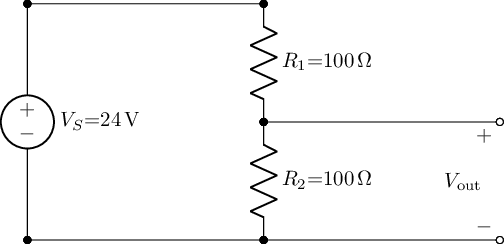

VS 1 0 24; down
W 1 2 ;  right, size=2
R1 2 3 100; down
R2 3 4 100; down
W 3 5; right, size=2
P1 5 6; down,v=V_{out}
W 4 6; right, size=2
W 4 0; left

In [29]:
cct1()

It's trivial to make an interactive widget built around the previous function that will create a diagram for us with components labeled according to values specified by input sliders:

In [30]:
from ipywidgets import interact_manual
cct_w = None

@interact_manual
def i_cct1(V='24', R1='', R2='100'):
    global cct_w
    cct_w = cct1(V=V,R1=R1,R2=R2)
    
#We could then select R and V values and extend the function
# to calculate V_out automatically

interactive(children=(Text(value='24', description='V'), Text(value='', description='R1'), Text(value='100', d…

In [31]:
# We could also plot V_out vs R_1 for given V_S and R_2?

In [32]:
cct_w.sch

AttributeError: 'NoneType' object has no attribute 'sch'